In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import folium
import openpyxl
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
%matplotlib inline

#pd.set_option('display.max_colwidth', None)

In [2]:
#COVID POSITIVE CASES
covid_pos = pd.read_csv("data/COVID_CountByZipPerDate03292021.csv")
covid_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Specimen Collection Date  8832 non-null   object 
 1   Zip                       8456 non-null   float64
 2   Cases                     8832 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 207.1+ KB


In [3]:
#clean up: rename columns, cast zip as object, split off '.0'
covid_pos = covid_pos.rename(columns={'Specimen Collection Date':'Test Date', 'Zip':'zip'})
covid_pos['zip'] = covid_pos['zip'].astype('str')
covid_pos['zip'] = covid_pos['zip'].apply(lambda x: x.split('.0')[0])
covid_pos.head()

,Test Date,zip,Cases
0,3/6/2020,37217,1
1,3/10/2020,37214,1
2,3/11/2020,37013,1
3,3/11/2020,37204,2
4,3/11/2020,37205,1


In [4]:
#group positive cases by zip code
pos_per_zip = covid_pos.groupby('zip')['Cases'].sum().reset_index()
pos_per_zip.head()
#pos_per_zip.shape (32 zips)

,zip,Cases
0,37013,13354
1,37027,231
2,37069,16
3,37072,2984
4,37076,4279


In [5]:
#COVID VACCINATIONS
covid_vacc = pd.read_csv("data/vaccine_with_protocol.csv")
covid_vacc['zipcode'] = covid_vacc['zipcode'].astype('str')
covid_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vacc_date    6694 non-null   object 
 1   zipcode      6694 non-null   object 
 2   count_given  6686 non-null   float64
 3   dose_nbr     6686 non-null   float64
 4   protocol     6694 non-null   object 
dtypes: float64(2), object(3)
memory usage: 261.6+ KB


In [6]:
#rename zipcode column to zip & verify/check null values
covid_vacc = covid_vacc.rename(columns={'zipcode':'zip'})
covid_vacc['zip'] = covid_vacc['zip'].apply(lambda x: x.split('.0')[0])
covid_vacc.head()
#covid_vacc.isnull().sum()


,vacc_date,zip,count_given,dose_nbr,protocol
0,2020-12-12,37215,1.0,1.0,two-shot
1,2020-12-14,37205,1.0,2.0,two-shot
2,2020-12-14,37215,1.0,1.0,two-shot
3,2020-12-15,37221,1.0,1.0,two-shot
4,2020-12-16,37215,1.0,1.0,two-shot


In [7]:
#group vaccinations by zip code
covid_vacc_per_zip = covid_vacc.groupby('zip')['count_given'].sum().reset_index()
covid_vacc_per_zip['zip'] = covid_vacc_per_zip['zip'].astype('str')
#Why doesn't this work? covid_vacc_per_zip['zip'] = (covid_vacc_per_zip['zip'].str.split()).apply(lambda x: float(x[0].replace('.0', ''))) #DROP .0??
#covid_vacc_per_zip['zip'] = covid_vacc_per_zip['zip'].apply(lambda x: x.split('.0')[0])

covid_vacc_per_zip.head()
#covid_vacc_per_zip.shape (32 zips)

,zip,count_given
0,37013,27167.0
1,37027,506.0
2,37069,89.0
3,37072,13108.0
4,37076,16855.0


In [8]:
#32 zips in vaccine and positivity tables; here are the counts side by side
case_and_vax = pos_per_zip.merge(covid_vacc_per_zip, on='zip')
case_and_vax

,zip,Cases,count_given
0,37013,13354,27167.0
1,37027,231,506.0
2,37069,16,89.0
3,37072,2984,13108.0
4,37076,4279,16855.0
5,37080,574,3078.0
6,37115,4574,12827.0
7,37138,2359,10873.0
8,37189,479,1650.0
9,37201,299,756.0


In [9]:
#what happened to the nulls in zips in original dataframe?
covid_vacc_per_zip.isnull().sum()

zip            0
count_given    0
dtype: int64

In [10]:
#GEODATAFRAME ZIPCODES
zipcodes = gpd.read_file("data/zipcodes.geojson")
zipcodes.head()

,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [11]:
zipcodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   zip             56 non-null     object  
 1   objectid        56 non-null     object  
 2   po_name         56 non-null     object  
 3   shape_stlength  56 non-null     object  
 4   shape_starea    56 non-null     object  
 5   geometry        56 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 2.8+ KB


In [12]:
#POPULATIONS PER ZIP CODE
pop_by_zip = pd.read_csv("data/zipcode population.csv")
pop_by_zip['zip'] = pop_by_zip['zip'].astype('str')
pop_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   number    610 non-null    int64 
 1   zip       610 non-null    object
 2   lat,long  610 non-null    object
 3   city      610 non-null    object
 4   pop       610 non-null    object
dtypes: int64(1), object(4)
memory usage: 24.0+ KB


In [13]:
#The population of 37228 seemed off, so I replaced with the number from census reporter (seemed more accurate)
pop_by_zip['pop'] = pop_by_zip['pop'].replace(['331'],'1,615')

pop_by_zip.loc[pop_by_zip['zip']=='37228']


,number,zip,"lat,long",city,pop
142,143,37228,"36.196291, -86.803583","Nashville, Tennessee","1,615"


In [14]:
#found some fancy-schmancy code to split out commas so I could cast pop object to float #ASK ABOUT THIS! WHY DOESN'T
#SIMPLY SPLIT WORK?
pop_by_zip['pop'] = (pop_by_zip['pop'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
pop_by_zip['pop'] = pop_by_zip['pop'].astype('float')
pop_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   number    610 non-null    int64  
 1   zip       610 non-null    object 
 2   lat,long  610 non-null    object 
 3   city      610 non-null    object 
 4   pop       610 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 24.0+ KB


In [15]:
pop_by_zip.head()

,number,zip,"lat,long",city,pop
0,1,37916,"35.953657, -83.933148","Knoxville, Tennessee",11672.0
1,2,37614,"36.301650, -82.370809","Johnson City, Tennessee",2036.0
2,3,37212,"36.133973, -86.801471","Nashville, Tennessee",18547.0
3,4,37351,"35.104194, -85.264615","Lupton City, Tennessee",270.0
4,5,37744,"36.182885, -82.740218","Greeneville, Tennessee",372.0


In [16]:
#Combine zipcodes geodataframe with vaccincation dataframe to make choropleth plot
#Using left merge to also see zips without vaccines or without reports of them
#drop duplicate zips


geo_vaccine = zipcodes.merge(covid_vacc_per_zip, on = 'zip', how='left')
geo_vaccine = geo_vaccine.sort_values('count_given',ascending=False).reset_index()
geo_vaccine = geo_vaccine.drop_duplicates('zip')
geo_vaccine.head()

,index,zip,objectid,po_name,shape_stlength,shape_starea,geometry,count_given
0,49,37211,39,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",28477.0
1,7,37221,17,NASHVILLE,241372.3112694624,1266395059.4877319,"MULTIPOLYGON (((-86.97084 36.11644, -86.97084 ...",27622.0
2,51,37013,34,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",27167.0
3,32,37205,16,NASHVILLE,146801.80831498865,400978073.00933838,"MULTIPOLYGON (((-86.81907 36.13351, -86.81688 ...",24451.0
4,12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",20553.0


In [17]:
geo_vaccine.shape

(38, 8)

In [18]:
geo_vaccine.isnull().sum()
#what happened to the null zips in covid_vacc?

index             0
zip               0
objectid          0
po_name           0
shape_stlength    0
shape_starea      0
geometry          0
count_given       9
dtype: int64

In [19]:
#next merge population by zip to geo_vaccine, calculate percentage vaxxed, drop unneccessary columns

geo_vaccine_pop = geo_vaccine.merge(pop_by_zip, on = 'zip', how='inner')
geo_vaccine_pop = geo_vaccine_pop.drop(columns=['index','objectid','number','lat,long', 'city'])
geo_vaccine_pop['percent_vaxxed'] = round(((geo_vaccine_pop['count_given']/geo_vaccine_pop['pop'])*100),2)
geo_vaccine_pop = geo_vaccine_pop.sort_values('percent_vaxxed',ascending=False).reset_index()
geo_vaccine_pop.head()


,index,zip,po_name,shape_stlength,shape_starea,geometry,count_given,pop,percent_vaxxed
0,3,37205,NASHVILLE,146801.80831498865,400978073.00933838,"MULTIPOLYGON (((-86.81907 36.13351, -86.81688 ...",24451.0,21861.0,111.85
1,25,37219,NASHVILLE,21013.192337432083,6579013.4385986328,"MULTIPOLYGON (((-86.78609 36.17465, -86.78585 ...",891.0,830.0,107.35
2,12,37203,NASHVILLE,91285.438580354588,120649702.5546875,"MULTIPOLYGON (((-86.78734 36.16688, -86.78711 ...",11678.0,12781.0,91.37
3,5,37215,NASHVILLE,158698.30754566603,424774478.15600586,"MULTIPOLYGON (((-86.81428 36.12618, -86.81425 ...",19915.0,22112.0,90.06
4,16,37204,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ...",9723.0,11024.0,88.20


In [20]:
geo_vaccine_pop.shape

(36, 9)

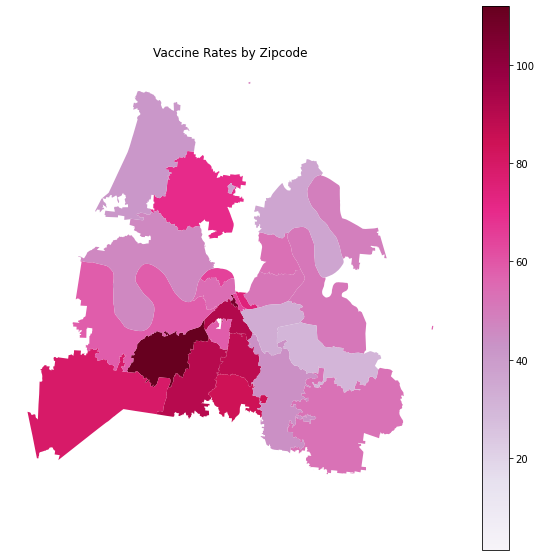

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
geo_vaccine_pop.plot(ax=ax, column = 'percent_vaxxed', cmap = 'PuRd', legend = True)
ax.axis('off')
plt.title('Vaccine Rates by Zipcode');

In [22]:
# Do I really need this to be here? Do we need interactivity?

# vacc_map = folium.Map(location = (36.174465, -86.767960), zoom_start = 10)
# folium.GeoJson(geo_vaccine).add_to(vacc_map)
# vacc_map

In [23]:
#Now to create same map with positivity rates by Zipcode. Start with merging geo zipcodes with positive cases by zip dataframe

geo_positivity = zipcodes.merge(pos_per_zip, on = 'zip', how='left')
geo_positivity = geo_positivity.sort_values('Cases',ascending=False).reset_index()
geo_positivity = geo_positivity.drop_duplicates('zip')
geo_positivity.head()


,index,zip,objectid,po_name,shape_stlength,shape_starea,geometry,Cases
0,51,37013,34,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",13354.0
1,49,37211,39,NASHVILLE,290587.58467925159,602215091.79736328,"MULTIPOLYGON (((-86.75696 36.13189, -86.75693 ...",10233.0
2,12,37209,10,NASHVILLE,310224.91345860378,1001364029.2892456,"MULTIPOLYGON (((-86.97543 36.20877, -86.97221 ...",5072.0
3,19,37207,49,NASHVILLE,14456.130686344946,6987521.0933837891,"MULTIPOLYGON (((-86.78596 36.29097, -86.78595 ...",4729.0
5,0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ...",4574.0


In [24]:
geo_positivity.shape

(38, 8)

In [25]:
#merge population by zip with positivity by zip

geo_pos_pop = geo_positivity.merge(pop_by_zip, on = 'zip', how='inner')
geo_pos_pop = geo_pos_pop.drop(columns=['index','objectid','number','lat,long', 'city'])
geo_pos_pop['percent_pos'] = round(((geo_pos_pop['Cases']/geo_pos_pop['pop']))*100,2)
geo_pos_pop = geo_pos_pop.sort_values('percent_pos',ascending=False).reset_index()
geo_pos_pop.head()

,index,zip,po_name,shape_stlength,shape_starea,geometry,Cases,pop,percent_pos
0,28,37213,NASHVILLE,30678.541831175633,23392261.943359375,"MULTIPOLYGON (((-86.77787 36.17706, -86.77810 ...",65.0,137.0,47.45
1,26,37219,NASHVILLE,21013.192337432083,6579013.4385986328,"MULTIPOLYGON (((-86.78609 36.17465, -86.78585 ...",270.0,830.0,32.53
2,9,37203,NASHVILLE,91285.438580354588,120649702.5546875,"MULTIPOLYGON (((-86.78734 36.16688, -86.78711 ...",3346.0,12781.0,26.18
3,0,37013,ANTIOCH,349164.88029162859,1150567551.5894165,"MULTIPOLYGON (((-86.66517 36.09108, -86.66526 ...",13354.0,51343.0,26.01
4,25,37201,NASHVILLE,25670.555742711778,11151362.94934082,"MULTIPOLYGON (((-86.77973 36.17460, -86.77823 ...",299.0,1167.0,25.62


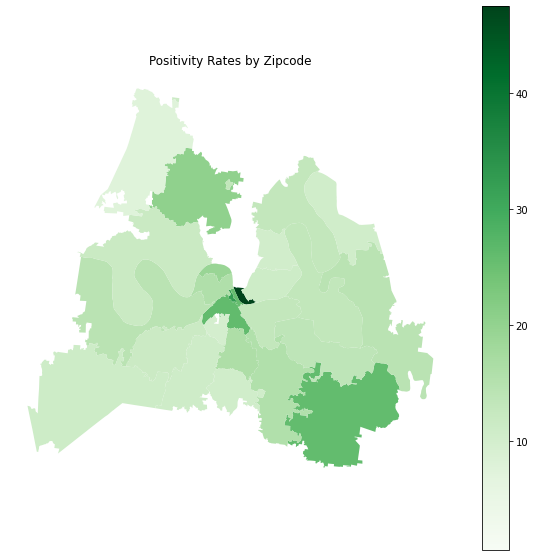

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
geo_pos_pop.plot(ax=ax, column = 'percent_pos', cmap = 'Greens', legend = True)
ax.axis('off')
plt.title('Positivity Rates by Zipcode');

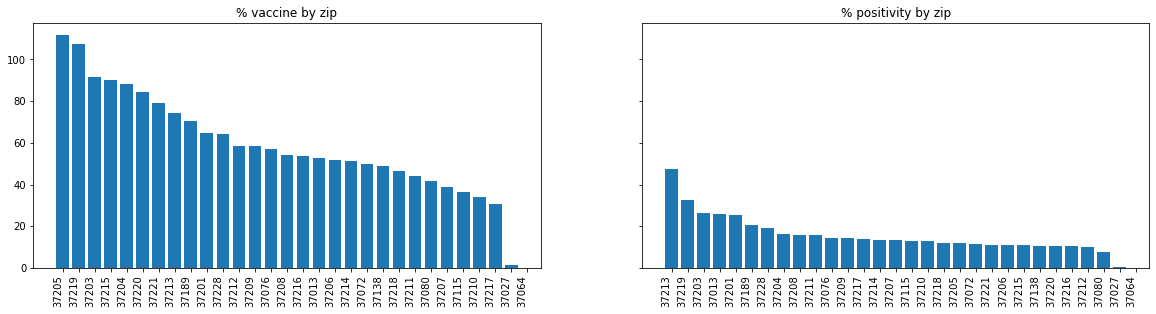

In [27]:
#Bar charts to show the same as above, and to identify any zipcodes of interest
fig, (ax1,ax2) = plt.subplots(figsize=(20,5), nrows=1, ncols=2, sharey=True)
ax1.bar(geo_vaccine_pop['zip'],geo_vaccine_pop['percent_vaxxed'])
ax2.bar(geo_pos_pop['zip'],geo_pos_pop['percent_pos'])
fig.autofmt_xdate(rotation= 90)
ax1.set_title('% vaccine by zip')
ax2.set_title('% positivity by zip');

In [28]:
#New data frame to show zip, city name, cases, vaccines, populations, and percentages of vaxxed and positive

compare_vacc_pos = geo_pos_pop.merge(geo_vaccine_pop, on = 'zip', how='left')
compare_vacc_pos = compare_vacc_pos.drop(columns=['index_x','shape_stlength_x','shape_starea_x', 'geometry_x',
                                                 'index_y','po_name_y','shape_stlength_y','shape_starea_y',
                                                 'geometry_y', 'pop_y'])
compare_vacc_pos = compare_vacc_pos.rename(columns={'po_name_x':'name','Cases':'cases','pop_x':'population',
                                                    'percent_pos':'%positive', 'Vaccines':'vaccines',
                                                    'count_given':'Vaccines','percent_vaxxed':'%vaxxed'})
compare_vacc_pos = compare_vacc_pos.sort_values('%positive',ascending=False)
compare_vacc_pos


,zip,name,cases,population,%positive,Vaccines,%vaxxed
0,37213,NASHVILLE,65.0,137.0,47.45,102.0,74.45
1,37219,NASHVILLE,270.0,830.0,32.53,891.0,107.35
2,37203,NASHVILLE,3346.0,12781.0,26.18,11678.0,91.37
3,37013,ANTIOCH,13354.0,51343.0,26.01,27167.0,52.91
4,37201,NASHVILLE,299.0,1167.0,25.62,756.0,64.78
5,37189,WHITES CREEK,479.0,2343.0,20.44,1650.0,70.42
6,37228,NASHVILLE,310.0,1615.0,19.20,1040.0,64.40
7,37204,NASHVILLE,1786.0,11024.0,16.20,9723.0,88.20
8,37208,NASHVILLE,2428.0,15272.0,15.90,8262.0,54.10
9,37211,NASHVILLE,10233.0,64753.0,15.80,28477.0,43.98


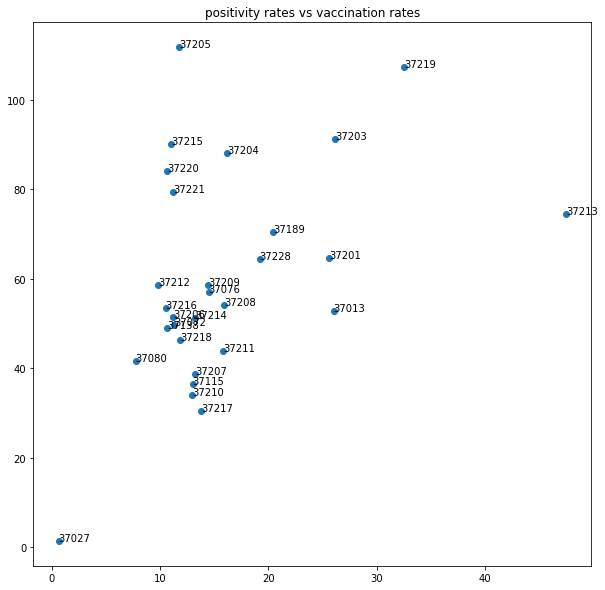

In [29]:
#scatter plot to see if there is a correlation between positivity rate and vaccination. Looks like there is a small correlation
#higher positivity rates are somewhat showing higher vaccination rates
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(compare_vacc_pos['%positive'],compare_vacc_pos['%vaxxed'])
ax.set_title('positivity rates vs vaccination rates')
for i, label in enumerate(compare_vacc_pos['zip']):
    plt.annotate(label, (compare_vacc_pos['%positive'][i], compare_vacc_pos['%vaxxed'][i]))

In [30]:
for i, label in enumerate(compare_vacc_pos['zip']):
    print(label, (compare_vacc_pos['%positive'][i], compare_vacc_pos['%vaxxed'][i]))

37213 (47.45, 74.45)
37219 (32.53, 107.35)
37203 (26.18, 91.37)
37013 (26.01, 52.91)
37201 (25.62, 64.78)
37189 (20.44, 70.42)
37228 (19.2, 64.4)
37204 (16.2, 88.2)
37208 (15.9, 54.1)
37211 (15.8, 43.98)
37076 (14.48, 57.04)
37209 (14.46, 58.59)
37217 (13.81, 30.44)
37214 (13.25, 51.27)
37207 (13.23, 38.85)
37115 (13.0, 36.45)
37210 (12.99, 33.97)
37218 (11.84, 46.34)
37205 (11.74, 111.85)
37072 (11.31, 49.68)
37221 (11.23, 79.35)
37206 (11.21, 51.57)
37215 (11.03, 90.06)
37138 (10.65, 49.07)
37220 (10.64, 84.21)
37216 (10.51, 53.59)
37212 (9.83, 58.65)
37080 (7.76, 41.63)
37027 (0.65, 1.42)
37064 (nan, nan)
37143 (nan, nan)
37135 (nan, nan)
37015 (nan, nan)
37122 (nan, nan)
37086 (nan, nan)
37152 (nan, nan)


In [31]:
#how to quickly organize income data
income_data = pd.read_excel("data/income by zip.xlsx", skiprows = 1, header=[0, 1], sheet_name = 0)
income_data = income_data[income_data.columns.drop(list(income_data.filter(regex='Error')))]
income_data.columns = income_data.columns.droplevel(1)

income_clean = income_data.set_index('Unnamed: 0_level_0').T.reset_index().rename({"index": "zipcode"}, axis = 1)
income_clean

Unnamed: 0_level_0,zipcode,Total:,"Less than $10,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999","$35,000 to $39,999","$40,000 to $44,999","$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","$100,000 to $124,999","$125,000 to $149,999","$150,000 to $199,999","$200,000 or more"
0,37013,35597,1424,1023,1197,1751,1647,1685,1748,1937,1748,3956,4510,5507,3547,1703,1212,1002
1,37015,6673,421,256,115,415,365,452,350,277,323,719,903,903,639,294,157,84
2,37027,19950,460,173,246,250,254,250,316,538,472,597,1235,1861,2167,1688,2837,6606
3,37062,4040,119,122,138,140,123,124,121,216,140,329,569,645,468,342,286,158
4,37064,21640,771,302,623,512,609,630,721,495,567,1479,1784,2293,2338,2265,2394,3857
5,37072,12533,534,412,456,674,687,506,518,568,544,1095,1311,2186,1120,784,652,486
6,37073,5425,233,151,169,236,290,325,282,184,288,549,557,698,620,262,399,182
7,37075,24275,743,422,553,687,682,986,1058,948,1011,2052,3003,3497,2271,2203,2004,2155
8,37076,17389,698,405,626,496,946,740,912,662,918,1445,2146,2648,1709,1167,1193,678
9,37080,3012,112,119,254,131,188,107,225,101,92,264,262,384,263,161,161,188


In [32]:
ethnic_data = pd.read_excel("data/race and ethnicity by zip.xlsx", skiprows = 1, header=[0, 1], sheet_name = 0)
ethnic_data = ethnic_data[ethnic_data.columns.drop(list(ethnic_data.filter(regex='Error')))]
ethnic_data

,Unnamed: 0_level_0,37010,37012,37013,37014,37015,37016,37020,37022,37025,...,38482,38483,38487,38547,38548,38552,38560,38563,38567,38569
,Unnamed: 0_level_1,Value,Value,Value,Value,Value,Value,Value,Value,Value,...,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
0,Total:,4966,2185,97939,2835,17665,950,5984,6583,5698,...,1635,5910,1044,1939,931,157,1405,3410,685,69
1,Not Hispanic or Latino:,4803,2134,81131,2783,16768,944,5824,6286,5698,...,1574,5748,1022,1912,931,157,1405,3410,660,69
2,White alone,4502,2050,40080,2682,15842,939,5137,5968,5526,...,1525,5608,838,1884,930,157,1307,3202,615,69
3,Black or African American alone,245,73,33280,18,304,0,222,173,24,...,0,31,113,0,0,0,0,140,0,0
4,American Indian and Alaska Native alone,2,0,95,0,147,0,99,32,0,...,0,0,0,28,1,0,2,0,0,0
5,Asian alone,27,3,4250,47,107,0,58,12,63,...,12,0,52,0,0,0,61,13,0,0
6,Native Hawaiian and Other Pacific Islander alone,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Some other race alone,0,0,374,0,5,0,5,0,0,...,0,0,0,0,0,0,0,39,0,0
8,Two or more races:,27,8,3052,36,363,3,303,101,85,...,37,109,19,0,0,0,35,16,45,0


In [33]:
pop_data = ethnic_data.set_index('Unnamed: 0_level_0').T.reset_index().rename({"index": "zip"}, axis = 1)
pop_data = ethnic_data.rename(columns={'(Total:,)':'population'})
# pop_data# pop_data = pop_data[['(Total:,)']]
pop_data

,Unnamed: 0_level_0,37010,37012,37013,37014,37015,37016,37020,37022,37025,...,38482,38483,38487,38547,38548,38552,38560,38563,38567,38569
,Unnamed: 0_level_1,Value,Value,Value,Value,Value,Value,Value,Value,Value,...,Value,Value,Value,Value,Value,Value,Value,Value,Value,Value
0,Total:,4966,2185,97939,2835,17665,950,5984,6583,5698,...,1635,5910,1044,1939,931,157,1405,3410,685,69
1,Not Hispanic or Latino:,4803,2134,81131,2783,16768,944,5824,6286,5698,...,1574,5748,1022,1912,931,157,1405,3410,660,69
2,White alone,4502,2050,40080,2682,15842,939,5137,5968,5526,...,1525,5608,838,1884,930,157,1307,3202,615,69
3,Black or African American alone,245,73,33280,18,304,0,222,173,24,...,0,31,113,0,0,0,0,140,0,0
4,American Indian and Alaska Native alone,2,0,95,0,147,0,99,32,0,...,0,0,0,28,1,0,2,0,0,0
5,Asian alone,27,3,4250,47,107,0,58,12,63,...,12,0,52,0,0,0,61,13,0,0
6,Native Hawaiian and Other Pacific Islander alone,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Some other race alone,0,0,374,0,5,0,5,0,0,...,0,0,0,0,0,0,0,39,0,0
8,Two or more races:,27,8,3052,36,363,3,303,101,85,...,37,109,19,0,0,0,35,16,45,0
